In [6]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd

In [7]:

df_c = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_d = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
df_r = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
def make_data(df):
    df.set_index(['Province/State', 'Country/Region', 'Lat', 'Long'], inplace=True)
    df = (df.
         stack().
        reset_index().
        rename(columns={'level_4':'issue_date', 0:'cant', 'Country/Region':'Country'})
    )
    df = df.groupby(['Country','issue_date']).sum().drop(['Lat','Long'], axis=1).reset_index()
    df.issue_date = pd.to_datetime(df.issue_date)
    df = df.set_index(['issue_date','Country']).unstack()
    df = df.loc[:, 'cant']
    return df

In [8]:
df_c = make_data(df_c)
df_d = make_data(df_d)
df_r = make_data(df_r)
df_rate = (df_d / df_c).fillna(0).replace(np.inf, 0)
df_act = df_c - df_d - df_r

In [14]:
PAIS = 'Italy'
data = df_act[PAIS][df_act[PAIS]>=1000].values

# A grid of time points (in days)
t = np.linspace(0, len(data), len(data))

## SIR model

In [11]:
import Python.sir_ode as sir_ode

In [13]:
params = [0.4, 0.25, 80000.0]
paramnames = ['beta', 'gamma', 'k']
ini = sir_ode.x0fcn(params,data)
ini

[0.9868375, 0.0131625, 0.0]

In [16]:
res = odeint(sir_ode.model, ini, t, args=(params,))

In [4]:
# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [5]:
def solver(deriv, y0, t, args):
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=args)
    return ret.T

def plot_sir(S, I , R):
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    fig = plt.figure(facecolor='w')
    #ax = fig.add_subplot(111, axis_bgcolor='#dddddd', axisbelow=True)
    ax = fig.add_subplot(111, axisbelow=True)
    ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
    ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Number (1000s)')
    #ax.set_ylim(0,1.2)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()


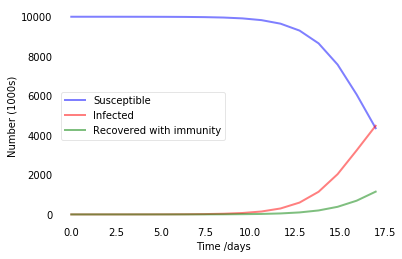

In [6]:


# Total population, N.
N = 10000

# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 100, 0

# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.8, 1./9

# A grid of time points (in days)
t = np.linspace(0, 17, 17)
# Initial conditions vector
y0 = [S0, I0, R0]

S, I, R = solver(deriv, y0, t, (N, beta, gamma))
plot_sir(S, I , R)

In [7]:
def SSE(y_true, y_pred):
    return (np.square(y_true - y_pred)).sum()

In [8]:
PAIS = 'Italy'
act = df_act[PAIS][df_act[PAIS]>=1000].values

In [9]:
# Total population, N.
Ns = np.arange(10000, 1000000, 10000)

# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1000, 0

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
gamma = 1./9
betas = np.linspace(1., 500, 100)/100

# A grid of time points (in days)
t = np.linspace(0, len(act), len(act))

all_result = []
for N in Ns:
    beta_result = [] 

    # Everyone else, S0, is susceptible to infection initially.
    S0 = N - I0 - R0
    y0 = [S0, I0, R0]

    for beta in betas:        
        S, I, R = solver(deriv, y0, t, (N, beta, gamma))
        beta_result.append(SSE(act, I))
        
    all_result.append(beta_result)
all_result = np.array(all_result)

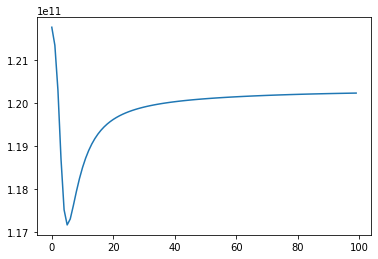

In [10]:
plt.plot(all_result[0]); plt.show()

In [168]:
minN = all_result.min(axis=1).argmin()
minb = all_result.min(axis=0).argmin()
N=Ns[minN]
beta=betas[minb]
print('N: {}, beta:{}'.format(N, beta))

N: 290000, beta:0.31242424242424244


TypeError: odeint() got an unexpected keyword argument 'args'

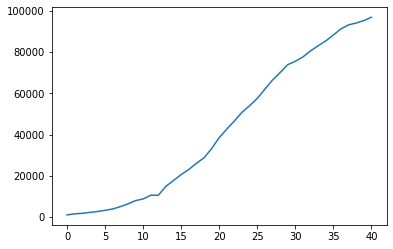

In [22]:
plt.plot(act)
S0 = N - I0 - R0
y0 = [S0, I0, R0]
S, I, R = solver(deriv, y0, t, (N, beta, gamma))
SSE(act, I)
plt.plot(I)
plt.show()

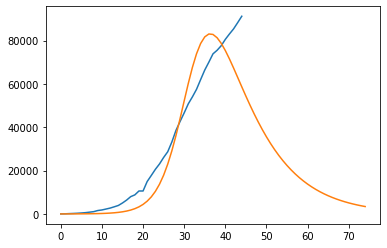

In [164]:
plt.plot(act)
t = np.linspace(0, 75, 75)
S, I, R = solver(deriv, y0, t, (N, beta, gamma))
plt.plot(I); plt.show()

## Use of pytorch ODEint

In [28]:
from torchdiffeq import odeint
import torch.nn as nn

In [25]:
class ODEFunc(nn.Module):
    def __init__(self, N, beta, gamma):
        super(ODEFunc, self).__init__()
        self.N = N
        self.beta = beta
        self.gamma = gamma

    def forward(self, t, y):
        S, I, R = y
        dSdt = -self.beta * S * I / self.N
        dIdt = self.beta * S * I / self.N - self.gamma * I
        dRdt = self.gamma * I
        return dSdt, dIdt, dRdt


In [29]:
deriv = ODEFunc(1000, 0.1, 0.3)
def solver(deriv, y0, t):
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t)
    return ret.T

In [30]:
# Total population, N.
N = 10000000

# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 100, 0

# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.8, 1./9

# A grid of time points (in days)
t = np.linspace(0, 17, 17)
# Initial conditions vector
y0 = torch.tensor([S0, I0, R0])

S, I, R = solver(deriv, y0, t)

AssertionError: y0 must be either a torch.Tensor or a tuple

## Optimizing with pytorch

In [15]:
import torch 
import torch.optim as optim

In [12]:
# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def model(deriv=deriv, I0, t, params):
    R0 = 0
    N = args[0]
    S0 = N - I0 - R0
    y0 = [S0, I0, R0]
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=params)
    return ret.T

def loss_fn(y_true, y_pred):
    return (np.square(y_true - y_pred)).sum()

In [16]:
def training_loop(n_epochs, optimizer, I0, t, params, y_true):
    for epoch in range(1, n_epochs + 1):
        y_pred = model(deriv=deriv, I0=I0, t=t, *params)
        loss = loss_fn(y_true, y_pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return params

In [ ]:
params = torch.tensor([10000, .5, .5], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(n_epochs = 5000,
                optimizer = optimizer,
                params = params,
                y_true = t_un,
                t_c = t_c)